### **Contents:**
1.  <a href='#load'>Loading the Data</a>
2.  <a href='#bow'>Featurization: Bag of Words (unigram) </a> 
    1.  <a href='#mnb'>MultinomialNaiveBayes</a>
    1. <a href='#lr'>Logistic Regression</a>
    1. <a href='#svm'>SVM</a>
1. <a href='#bi'>BOW : Bi-gram </a>
    1.  <a href='#bmnb'>MultinomialNaiveBayes</a>
    1. <a href='#blr'>Logistic Regression</a>
    1. <a href='#bsvm'>SVM</a>
1. <a href='#tfidf'>TF-IDF</a>
    1.  <a href='#tmnb'>MultinomialNaiveBayes</a>
    1. <a href='#tlr'>Logistic Regression</a>
    1. <a href='#tsvm'>SVM</a>
1. <a href='#con'>Conclusion</a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


<a id='load'></a>
## **Loading the Data**

In [2]:
df = pd.read_pickle('text_df')

In [3]:
df.describe(include='all')

,Summary,score
count,787287,787287.000000
unique,646560,NaN
top,locat,NaN
freq,14700,NaN
mean,NaN,0.567595
std,NaN,0.495410
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [4]:
df.sample(10)

,Summary,score
491288,could spruce rather d,0
591247,thing parking hotel expens,0
558418,rooms small cold bathroom sheets small hard,0
378602,friendly welcoming staff,1
449204,room smal,0
514567,staff awful rooms tiny dated satisfactory sta...,0
366086,take breakfast far expens,1
375327,location great close catalunya sq across stre...,1
59730,given refurbished room comfortable staff help...,1
270581,property next tram city centre minute commut,1


In [5]:
#converting the data into numpy arrays
summary = np.array(df.Summary)
score = list(df.score)

In [6]:
# To display the Confusion matrix
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, false negative, true positive
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN # Total num of examples

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

<a id='bow'></a>
## **Featurizer - Bag of words** (Unigram)
<a id='mnb'></a>
## 1. Multinomial Naive Bayes:

In [7]:
start_time = time.time()

# Hyperparameters for NaiveBayes(alpha--> 1,3,5,7,9....49)
myList = list(range(0,50)) 
parameters = {'alpha': list(filter(lambda x: x % 2 != 0, myList))} 

# Splliting the data into train, test with 70% as train and 30% as test
x_train, x_test, y_train, y_test = train_test_split(summary, score, test_size=0.3, random_state=42)

# Unigram BOW
vec = CountVectorizer()
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)

# Using GridSearch with 5-Fold crossvalidation finding the best parameters.
nb = MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=5, n_jobs=-1)

# Fitting the training data
clf.fit(x_train, y_train)

print('Best parameters for MultinomialNB are:',clf.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for MultinomialNB are: {'alpha': 1}


Confusion matrix:
 [[ 89940  12077]
 [  7805 126365]]


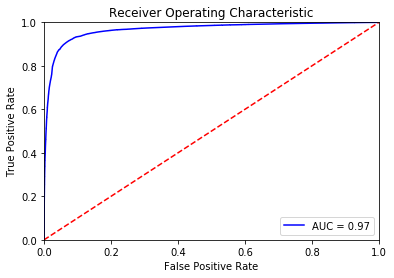

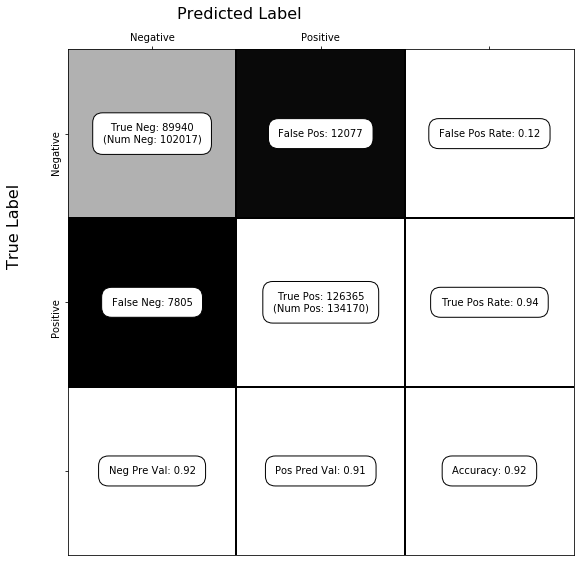

The log loss for the Naive bayes is: 0.3153943381510949
Precision : 91.27649123820805
Recall : 94.1827532235224
The accuracy is 91.58 %


In [8]:
# Using the best parameters obtained from the GridSearch and displaying the metrics
nb = MultinomialNB(alpha=clf.best_params_['alpha'])
y_pred = clf.predict(x_test)

conf_NB = confusion_matrix(y_test, y_pred)    
print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#print confusion matrix by calling the custom function
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
a = log_loss(y_test, probs)

print("The log loss for the Naive bayes is:",a)
print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='lr'></a>
## **2. Logistic Regression:**

In [9]:
#Logistic regression hyperparameter tuning

start_time = time.time()

best_params_logreg = []
parameters = {'loss' :['log'],'penalty':['l1','l2','elasticnet'],'alpha':[10**i for i in range(-4,3)] ,'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)

clf.fit(x_train, y_train)
best_params_logreg.append(clf.best_params_)

print('Best parameters for Logistic Regression are:',best_params_logreg)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for Logistic Regression are: [{'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}]
--- 273.520783662796 seconds ---


Confusion matrix:
 [[ 94977   7040]
 [ 11345 122825]]


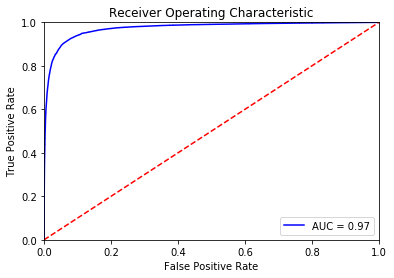

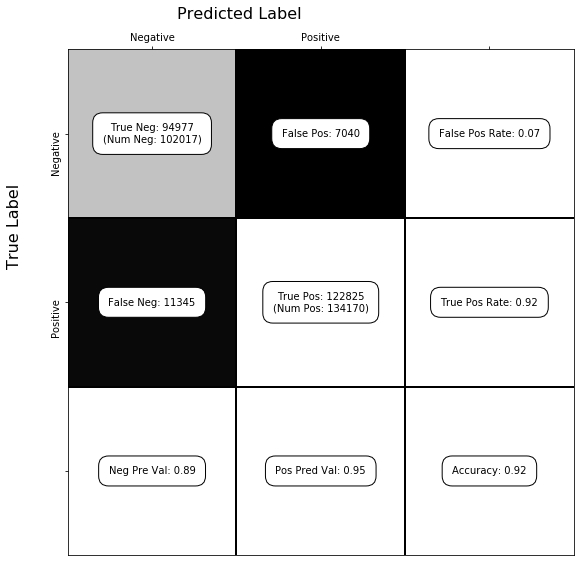

The log loss for the Naive bayes is: 0.21584664131728762
Precision : 94.57898586994186
Recall : 91.54430945815011
The accuracy is 92.22 %


In [11]:
clf = SGDClassifier(loss = 'log',penalty = 'l2',alpha = 0.0001, n_jobs = -1)
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_NB = confusion_matrix(y_test, y_pred)    
print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#print confusion matrix by calling the custom function
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
a = log_loss(y_test, probs)

print("The log loss for the Naive bayes is:",a)
print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='svm'></a>
## **3. Support Vector Machine:**

In [13]:
#SVM hyperparameter tuning
start_time = time.time()
best_params_SVM = []
parameters = {'loss' :['hinge'],'penalty':['l1','l2','elasticnet'],'alpha':[10**i for i in range(-4,3)],'n_jobs':[-1]}
 
clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)
clf.fit(x_train, y_train)
best_params_SVM = clf.best_params_
print("Best hyperparameters for linear SVM:",best_params_SVM)
print('------{} seconds-------'.format(time.time()-start_time))

Best hyperparameters for linear SVM: {'alpha': 0.0001, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
------276.74946427345276 seconds-------


Confusion matrix:
 [[ 94706   7311]
 [ 10395 123775]]


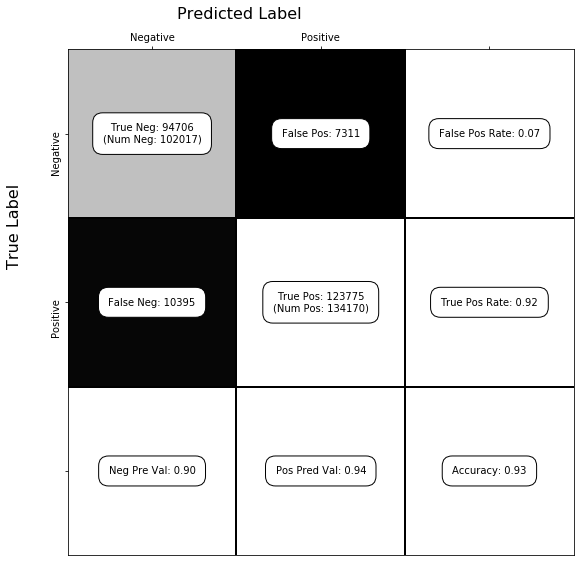

Precision : 94.42274537326641
Recall : 92.25236640083476
The accuracy is 92.5 %


In [14]:
#Linear SVM
clf = SGDClassifier(penalty = 'l2', alpha = 0.0001, n_jobs =  -1, loss = 'hinge')
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_SVM_ref = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",conf_SVM_ref)
#print confusion matrix
show_confusion_matrix(conf_SVM_ref,['Negative','Positive'])
#Precision and recall
tn = conf_SVM_ref[0,0]; fp = conf_SVM_ref[0,1]; fn = conf_SVM_ref[1,0]; tp = conf_SVM_ref[1,1];
precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
print("Precision :",precision)
print("Recall :",recall)
tp = conf_SVM_ref[0][0]
tn = conf_SVM_ref[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='bi'></a>
## **BOW Bi-gram** :MultinomialNB
<a id='bmnb'></a>

In [15]:
start_time = time.time()

# Hyperparameters for NaiveBayes(alpha--> 1,3,5,7,9....49)
myList = list(range(0,50)) 
parameters = {'alpha': list(filter(lambda x: x % 2 != 0, myList))} 

# Splliting the data into train, test with 70% as train and 30% as test
x_train, x_test, y_train, y_test = train_test_split(summary, score, test_size=0.3, random_state=42)

# Unigram BOW
vec = CountVectorizer(ngram_range=(2,2))
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)

# Using GridSearch with 5-Fold crossvalidation finding the best parameters.
nb = MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=5, n_jobs=-1)

# Fitting the training data
clf.fit(x_train, y_train)

print('Best parameters for MultinomialNB are:',clf.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for MultinomialNB are: {'alpha': 1}


Confusion matrix:
 [[ 84720  17297]
 [  4856 129314]]


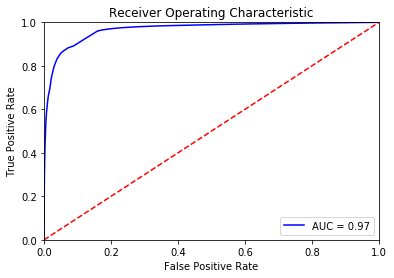

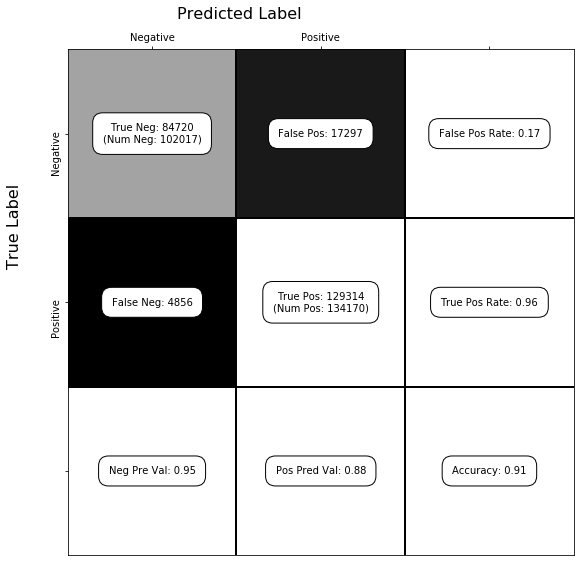

The log loss for the Naive bayes is: 0.31328256395092047
Precision : 88.20211307473518
Recall : 96.38071103823508
The accuracy is 90.62 %


In [16]:
# Using the best parameters obtained from the GridSearch and displaying the metrics
nb = MultinomialNB(alpha=clf.best_params_['alpha'])
y_pred = clf.predict(x_test)

conf_NB = confusion_matrix(y_test, y_pred)    
print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#print confusion matrix by calling the custom function
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
a = log_loss(y_test, probs)

print("The log loss for the Naive bayes is:",a)
print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='blr'></a>
## **2. Logistic Regression:**

In [17]:
#Logistic regression hyperparameter tuning

start_time = time.time()

best_params_logreg = []
parameters = {'loss' :['log'],'penalty':['l1','l2','elasticnet'],'alpha':[10**i for i in range(-4,3)] ,'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)

clf.fit(x_train, y_train)
best_params_logreg.append(clf.best_params_)

print('Best parameters for Logistic Regression are:',best_params_logreg)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for Logistic Regression are: [{'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}]
--- 335.48339200019836 seconds ---


Confusion matrix:
 [[ 95758   6259]
 [ 25360 108810]]


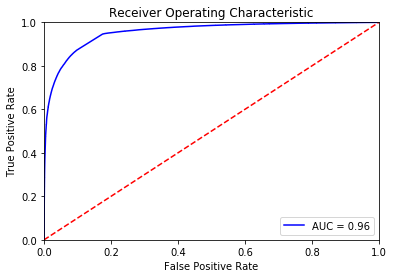

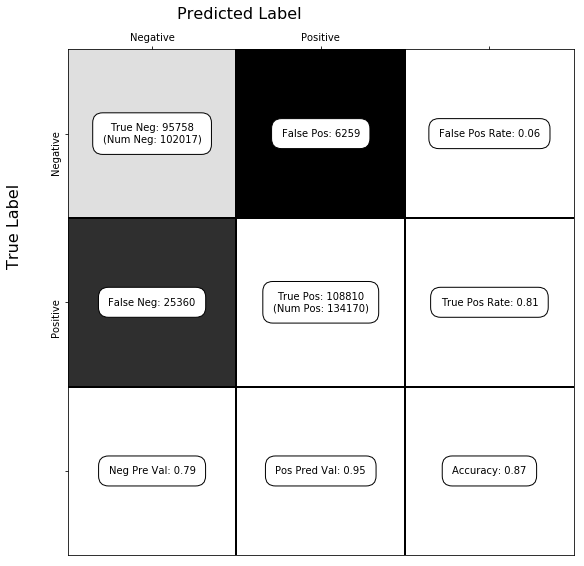

The log loss for the Naive bayes is: 0.33871951344291545
Precision : 94.56065491140099
Recall : 81.09860624580756
The accuracy is 86.61 %


In [18]:
clf = SGDClassifier(loss = 'log',penalty = 'l2',alpha = 0.0001, n_jobs = -1)
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_NB = confusion_matrix(y_test, y_pred)    
print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#print confusion matrix by calling the custom function
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
a = log_loss(y_test, probs)

print("The log loss for the Naive bayes is:",a)
print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='bsvm'></a>
## **3. Support Vector Machine:**

In [19]:
#SVM hyperparameter tuning
start_time = time.time()
best_params_SVM = []
parameters = {'loss' :['hinge'],'penalty':['l1','l2','elasticnet'],'alpha':[10**i for i in range(-4,3)],'n_jobs':[-1]}
 
clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)
clf.fit(x_train, y_train)
best_params_SVM = clf.best_params_
print("Best hyperparameters for linear SVM:",best_params_SVM)
print('------{} seconds-------'.format(time.time()-start_time))

Best hyperparameters for linear SVM: {'alpha': 0.0001, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
------220.65554189682007 seconds-------


Confusion matrix:
 [[ 97072   4945]
 [ 27087 107083]]


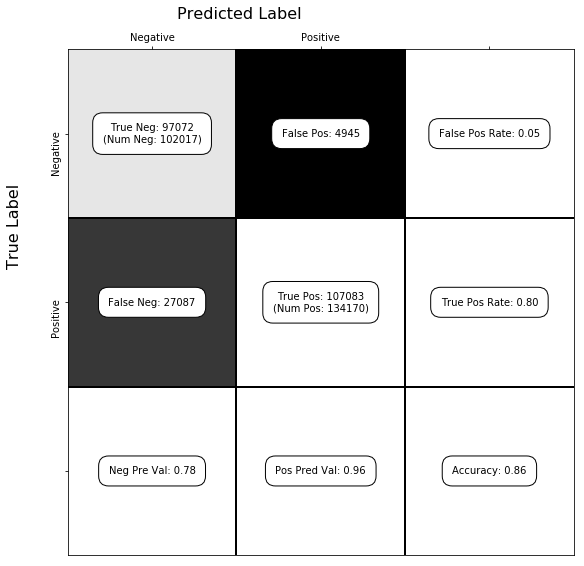

Precision : 95.58592494733459
Recall : 79.81143325631662
The accuracy is 86.44 %


In [20]:
#Linear SVM
clf = SGDClassifier(penalty = 'l2', alpha = 0.0001, n_jobs =  -1, loss = 'hinge')
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_SVM_ref = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",conf_SVM_ref)
#print confusion matrix
show_confusion_matrix(conf_SVM_ref,['Negative','Positive'])
#Precision and recall
tn = conf_SVM_ref[0,0]; fp = conf_SVM_ref[0,1]; fn = conf_SVM_ref[1,0]; tp = conf_SVM_ref[1,1];
precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
print("Precision :",precision)
print("Recall :",recall)
tp = conf_SVM_ref[0][0]
tn = conf_SVM_ref[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='tfidf'></a>
## **TF-IDF: Multinomial Naive Bayes**
<a id='tmnb'></a>

In [21]:
start_time = time.time()

# Hyperparameters for NaiveBayes(alpha--> 1,3,5,7,9....49)
myList = list(range(0,50)) 
parameters = {'alpha': list(filter(lambda x: x % 2 != 0, myList))} 

# Splliting the data into train, test with 70% as train and 30% as test
x_train, x_test, y_train, y_test = train_test_split(summary, score, test_size=0.3, random_state=42)

# Unigram BOW
vec = TfidfVectorizer()
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)

# Using GridSearch with 5-Fold crossvalidation finding the best parameters.
nb = MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=5, n_jobs=-1)

# Fitting the training data
clf.fit(x_train, y_train)

print('Best parameters for MultinomialNB are:',clf.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for MultinomialNB are: {'alpha': 1}
--- 204.03290271759033 seconds ---


Confusion matrix:
 [[ 90147  11870]
 [  8611 125559]]


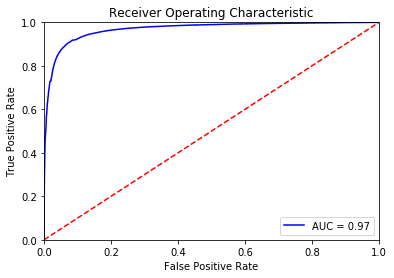

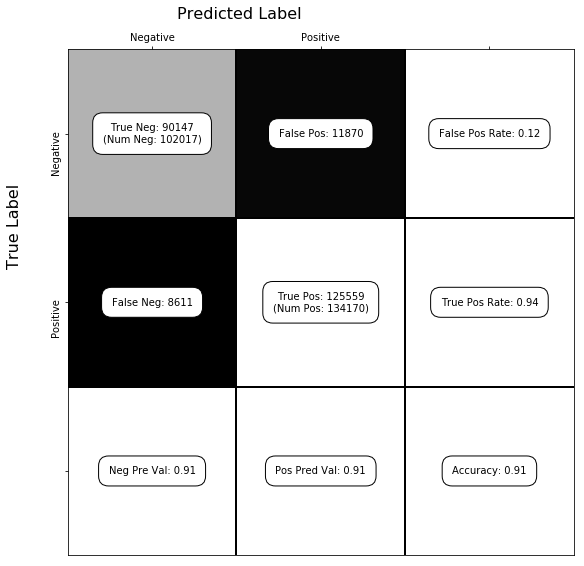

The log loss for the Naive bayes is: 0.23086849314263766
Precision : 91.36281279788109
Recall : 93.58202280688678
The accuracy is 91.33 %


In [22]:
# Using the best parameters obtained from the GridSearch and displaying the metrics
nb = MultinomialNB(alpha=clf.best_params_['alpha'])
y_pred = clf.predict(x_test)

conf_NB = confusion_matrix(y_test, y_pred)    
print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#print confusion matrix by calling the custom function
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
a = log_loss(y_test, probs)

print("The log loss for the Naive bayes is:",a)
print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='tlr'></a>
## **2. Logistic Regression:**

In [23]:
#Logistic regression hyperparameter tuning

start_time = time.time()

best_params_logreg = []
parameters = {'loss' :['log'],'penalty':['l1','l2','elasticnet'],'alpha':[10**i for i in range(-4,3)] ,'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)

clf.fit(x_train, y_train)
best_params_logreg.append(clf.best_params_)

print('Best parameters for Logistic Regression are:',best_params_logreg)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for Logistic Regression are: [{'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}]
--- 181.15922951698303 seconds ---


Confusion matrix:
 [[ 95315   6702]
 [ 12266 121904]]


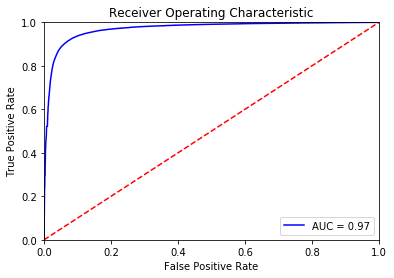

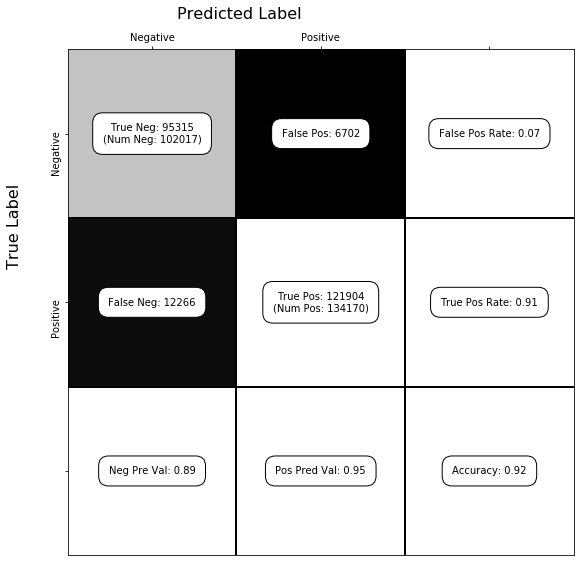

The log loss for the Naive bayes is: 0.2514795992352602
Precision : 94.78873458470056
Recall : 90.85786688529477
The accuracy is 91.97 %


In [24]:
clf = SGDClassifier(loss = 'log',penalty = 'l2',alpha = 0.0001, n_jobs = -1)
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_NB = confusion_matrix(y_test, y_pred)    
print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#print confusion matrix by calling the custom function
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
a = log_loss(y_test, probs)

print("The log loss for the Naive bayes is:",a)
print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='tsvm'></a>
## **3. Support Vector Machine:**

In [25]:
#SVM hyperparameter tuning
start_time = time.time()
best_params_SVM = []
parameters = {'loss' :['hinge'],'penalty':['l1','l2','elasticnet'],'alpha':[10**i for i in range(-4,3)],'n_jobs':[-1]}
 
clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)
clf.fit(x_train, y_train)
best_params_SVM = clf.best_params_
print("Best hyperparameters for linear SVM:",best_params_SVM)
print('------{} seconds-------'.format(time.time()-start_time))

Best hyperparameters for linear SVM: {'alpha': 0.0001, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
------160.3045210838318 seconds-------


Confusion matrix:
 [[ 96182   5835]
 [ 11993 122177]]


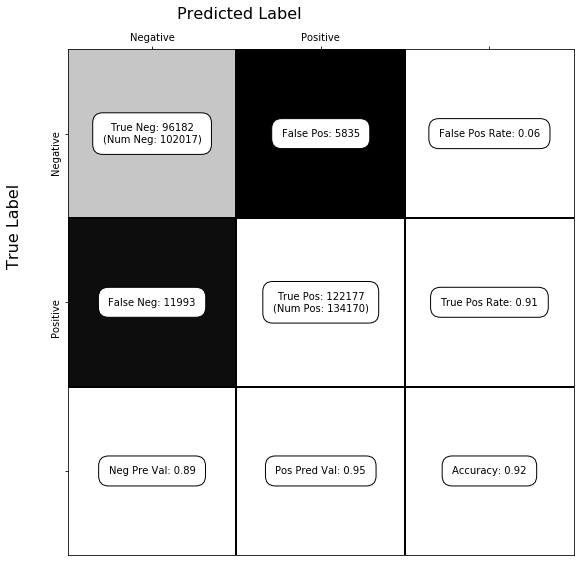

Precision : 95.44183357810205
Recall : 91.06134009092942
The accuracy is 92.45 %


In [27]:
#Linear SVM
clf = SGDClassifier(penalty = 'l2', alpha = 0.0001, n_jobs = -1, loss = 'hinge')
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_SVM_ref = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",conf_SVM_ref)
#print confusion matrix
show_confusion_matrix(conf_SVM_ref,['Negative','Positive'])
#Precision and recall
tn = conf_SVM_ref[0,0]; fp = conf_SVM_ref[0,1]; fn = conf_SVM_ref[1,0]; tp = conf_SVM_ref[1,1];
precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
print("Precision :",precision)
print("Recall :",recall)
tp = conf_SVM_ref[0][0]
tn = conf_SVM_ref[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

<a id='con'></a>
## **Conclusion :**
### 1. Accuracy of different models:
* BOW - unigram :
    * MultinomialNB : 91.58%    
    * Logistic Regression: 92.22%
    * SVM : 92.5%

* BOW - bigram :
    * MultinomialNB : 90.62%    
    * Logistic Regression: 86.61%
    * SVM : 86.44%

* TF_IDF:
    * MultinomialNB : 91.33%    
    * Logistic Regression: 91.97%
    * SVM : 92.45%

* Among all the models **Support Vector Machine** with **Unigram** is giving the best accuracy with **92.5%**